# Применение логистической регрессии для решения задачи классификации

# Описание набора данных

Данный набор содержит информацию о пассажирах корабля «Титаник», затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д.

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы — отдельный пассажир, вся информация о нем содержится в его строке. 

Описание датасета:
- **Survived** (целевой признак): выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass**: класс каюты (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: пол (female или male)	
- **Age**: возраст в годах
- **SibSp**: количество братьев, сестёр (в том числе сводных) и супругов на борту	
- **Parch**: количество детей и родителей на борту
- **Ticket**: номер билета	
- **Fare**: стоимость проезда пассажира	
- **Cabin**: номер каюты	
- **Embarked**: порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** — выживет ли пассажир — по соответсвующим ему нецелевым признакам.


# Подготовка и первичный анализ данных

In [214]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [215]:
data = pd.read_csv('/Users/muzafarov/Desktop/MyEducation/ML_OE/titanic_train.csv')

Установите количество пропущенных значений поля <code>age</code>:

In [216]:
data['age'].isna().sum()

199

Определите долю выживших

In [217]:
data['survived'].value_counts(1)

0    0.617737
1    0.382263
Name: survived, dtype: float64

Определите долю пропущенных значений в рамках каждого признака и избавьтесь от тех признаков, где доля пропусков больше трети. Также удалите колонку <code>ticket</code>, вряд ли эта информация будет полезной.

In [218]:
data = data.drop(columns='ticket')

In [219]:
data.isna().sum()/len(data)

pclass       0.000000
survived     0.000000
name         0.000000
sex          0.000000
age          0.202854
sibsp        0.000000
parch        0.000000
fare         0.000000
cabin        0.783894
embarked     0.000000
home.dest    0.422018
dtype: float64

In [220]:
data = data.drop(columns=['cabin', 'home.dest'])
data

,pclass,survived,name,sex,age,sibsp,parch,fare,embarked
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,7.7333,Q
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,7.7500,Q
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,7.2292,C
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,7.8958,S
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,9.5000,S
...,...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,0,0,8.0500,S
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,0,0,8.0500,S
978,2,0,"Gillespie, Mr. William Henry",male,34.0,0,0,13.0000,S
979,3,0,"Barton, Mr. David John",male,22.0,0,0,8.0500,S


Из описания набора данных видно, что колонки <code>sibsp</code> и <code>parch</code> по сути отвечают за размер семьи. Замените эти две колонки на колонку <code>fam_size</code>, значения которой будут вычисляться как сумма соответствующих значений в колонках <code>sibsp</code> и <code>parch</code>. 

In [221]:
data['fam_size'] = data['sibsp'] + data['parch']
data = data.drop(columns=['sibsp', 'parch'])
data

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0
...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,8.0500,S,0
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,8.0500,S,0
978,2,0,"Gillespie, Mr. William Henry",male,34.0,13.0000,S,0
979,3,0,"Barton, Mr. David John",male,22.0,8.0500,S,0


In [222]:
data['fam_size'].mean()

0.8664627930682977

Полученный датасет будем называть **исходным** (выброшенные на этом этапе признаки не нужно возвращать ни на одном из последующих этапов выполнения задания). Вычислите полученное число предикторов.

In [223]:
len(data.columns) - 1

7

На основе имеющейся статистики оцените вероятность выжить если пассажир -- представитель определенной категории (указана в вашем индивидуальном задании)

In [224]:
data_female = data[(data['pclass'] == 1) & (data['sex'] == 'female')]
data_female['survived'].value_counts(1)

1    0.971154
0    0.028846
Name: survived, dtype: float64

Постройте гистограммы выжиших и невыживших по возрастам.

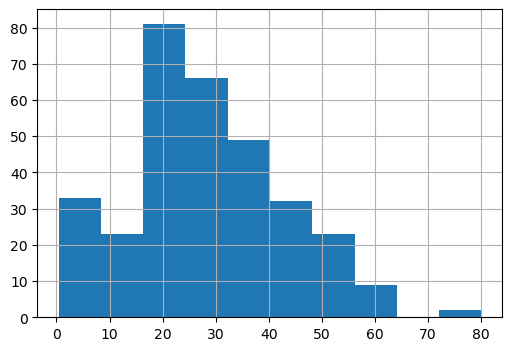

In [225]:
surv = data['age'][data['survived']==1]
not_surv = data['age'][data['survived']==0]
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()
 
ax.hist(surv)
ax.grid()

plt.show()

# Модель на основе числовых признаков

## Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалите все категориальные признаки, а также строки, содержащие пропуски.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки<b> с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>survived</code>.

Обучите модель <code>LogisticRegression()</code> <b>с параметрами, указанными в вашем задании</b>, на тренировочных данных, оцените на тестовых.

Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.



In [226]:
data

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0
...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,8.0500,S,0
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,8.0500,S,0
978,2,0,"Gillespie, Mr. William Henry",male,34.0,13.0000,S,0
979,3,0,"Barton, Mr. David John",male,22.0,8.0500,S,0


In [227]:
data.dtypes

pclass        int64
survived      int64
name         object
sex          object
age         float64
fare        float64
embarked     object
fam_size      int64
dtype: object

In [228]:
data_int = data.loc[:,data.dtypes != 'object']
data_int = data_int.dropna()
data_int

,pclass,survived,age,fare,fam_size
2,3,1,38.0,7.2292,0
3,3,0,22.0,7.8958,0
4,3,0,16.0,9.5000,0
5,3,1,29.0,7.7500,0
7,1,0,25.0,26.0000,0
...,...,...,...,...,...
975,2,0,19.0,10.5000,0
977,3,1,19.0,8.0500,0
978,2,0,34.0,13.0000,0
979,3,0,22.0,8.0500,0


In [229]:
X = data_int.drop(columns='survived')
y = data_int['survived']

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

In [231]:
model = LogisticRegression(random_state=7, max_iter=1000)
model.fit(X_train,y_train)
pred = model.predict(X_test)
f1_score(y_test,pred)

0.5283018867924528

## Заполнение пропусков средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски. Из исходного набора данных удалите категориальные признаки, а пропуски заполните средним по столбцу. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [232]:
# < ENTER YOUR CODE HERE > 

## Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке <code>age</code> средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку. 

Можно заметить, что исходный датасет в столбце <code>name</code> содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения <code>Mr., Mrs., Dr.</code> и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

Верните в рассмотрение колонку <code>name</code>. Создайте отдельную колонку <code>honorific</code> и поместите туда значения обращений.

Вычислите число уникальных обращений.

In [233]:
# < ENTER YOUR CODE HERE > 

Скорее всего имеет смысл сократить число обращений, добавив малочисленные группы к более многочисленным, так как принципиальной разницы между, например, <code>Don</code> и <code>Mr</code>, видимо, нет. Отметим, что <code>Master</code> — это прежнее обращение к ребенку, с этим обращением будем работать отдельно.




Выполните следующие замены:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [234]:
# < ENTER YOUR CODE HERE > 

Вычислите долю строк со значением <code>Master</code> относительно числа всех мужчин

In [235]:
# < ENTER YOUR CODE HERE > 

Вычислите средний возраст категории, указанной в вашем индивидуальном задании

In [236]:
# < ENTER YOUR CODE HERE > 

Заполните пропуски в колонке <code>age</code> средним, соответствующим среднему категории <code>honorific</code>.

Избавьтесь от нечисловых признаков. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [237]:
# < ENTER YOUR CODE HERE > 

# Модель с использование категориальных признаков

В исходном наборе данных заполните пропуски колонки <code>age</code> значениями на основе обращений (как в предыдущем пункте).

Не используйте признаки <code>name</code> и <code>honorific</code>. Они свою функцию выполнили.

Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>. Далее по знакомой схеме: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [238]:
# < ENTER YOUR CODE HERE > 